Блок 0. Загрузка модели и проверка устройства

In [4]:
import os
from ultralytics import YOLO
import torch

model_path = '../data/models/yolov8s.pt'

# Проверка наличия весов
if not os.path.exists(model_path):
    print(f"⚠️ Файл {model_path} не найден. YOLO скачает веса автоматически.")

# Проверка CUDA
print("🔍 CUDA доступен:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("✅ Устройство:", torch.cuda.get_device_name(0))
else:
    print("⚠️ Используется CPU")

# Загрузка модели
model = YOLO(model_path)


🔍 CUDA доступен: True
✅ Устройство: NVIDIA GeForce RTX 4070 SUPER


Блок 1. Выгрузка первого кадра из видео

In [5]:
import cv2

video_path = '../data/input_video/output.mp4'
output_image_path = '../data/outputs/first_frame.jpg'

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

if ret:
    cv2.imwrite(output_image_path, frame)
    print("✅ Сохранено:", output_image_path)
else:
    print("❌ Не удалось считать кадр!")

cap.release()


✅ Сохранено: ../data/outputs/first_frame.jpg


Блок 2. Определение координат линии подсчёта

In [6]:
# Линия пересечения (по пешеходному переходу)
LINE = ((946, 562), (1077, 547))

# ROI: область вокруг пешеходного перехода (x, y, w, h)
ROI = (800, 480, 500, 300)  


Блок 3. Визуальная проверка линии на кадре

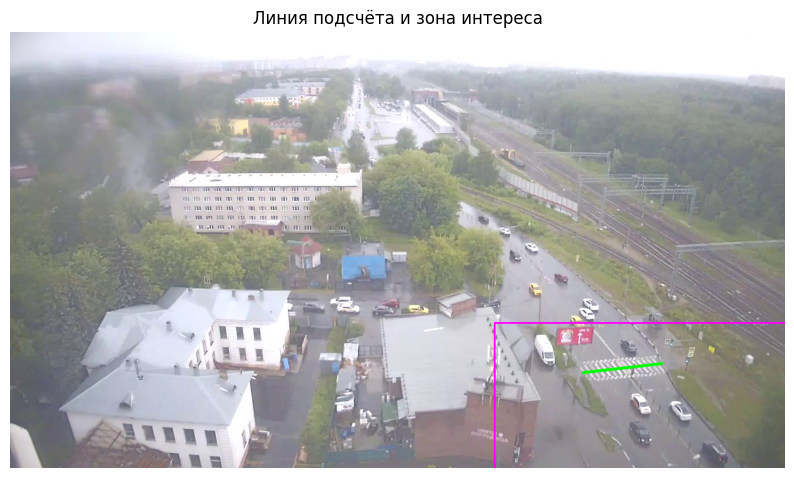

In [7]:
import matplotlib.pyplot as plt

frame = cv2.imread('../data/outputs/first_frame.jpg')

# Линия
cv2.line(frame, LINE[0], LINE[1], (0, 255, 0), 3)

# ROI
x, y, w, h = ROI
cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 255), 2)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Линия подсчёта и зона интереса")
plt.show()


Блок 4. Подсчёт машин с визуализацией (YOLO + BoT-SORT)
*подсчет автомобилей пересекающих линию сверху вниз

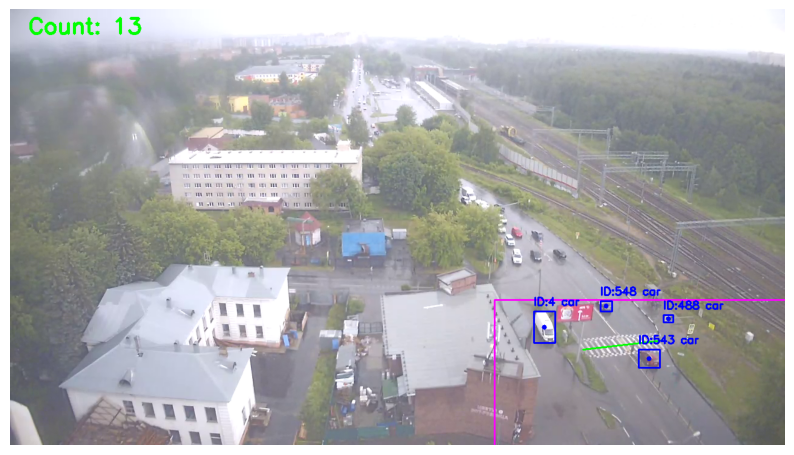

In [8]:
from IPython.display import clear_output

cap = cv2.VideoCapture(video_path)

tracked_once = set()
last_cy = {}
count = 0

COCO_CLASSES = model.model.names  # Названия классов COCO

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Вырезаем ROI
    x, y, w, h = ROI
    frame_roi = frame[y:y+h, x:x+w]

    results = model.track(
        frame_roi,
        persist=True,
        classes=[2, 3, 5, 7],  # car, motorcycle, bus, truck
        tracker="botsort.yaml",
        verbose=False
    )[0]

    # Рисуем на оригинальном кадре
    cv2.line(frame, LINE[0], LINE[1], (0, 255, 0), 2)
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 255), 2)

    if results.boxes is not None and results.boxes.id is not None:
        for box in results.boxes:
            if box.id is None:
                continue

            # Координаты внутри ROI
            bx1, by1, bx2, by2 = map(int, box.xyxy[0])
            track_id = int(box.id[0])
            cls_id = int(box.cls[0])
            label_name = COCO_CLASSES[cls_id]

            # Смещение обратно в оригинальный кадр
            x1, y1, x2, y2 = bx1 + x, by1 + y, bx2 + x, by2 + y
            cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)
            prev_cy = last_cy.get(track_id, cy)

            # Подсчёт при пересечении снизу вверх
            if track_id not in tracked_once:
                if prev_cy < LINE[0][1] and cy >= LINE[0][1]:
                    count += 1
                    tracked_once.add(track_id)

            last_cy[track_id] = cy

            # Отрисовка
            color = (0, 0, 255) if track_id in tracked_once else (255, 0, 0)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.circle(frame, (cx, cy), 4, color, -1)
            cv2.putText(
                frame,
                f"ID:{track_id} {label_name}",
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                color,
                2
            )

    # Счётчик
    cv2.putText(frame, f"Count: {count}", (30, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    clear_output(wait=True)
    plt.show()

cap.release()


Блок 5. Экспорт размеченного видео

In [9]:
import cv2
from ultralytics import YOLO
import torch
import os

# Пути
video_path = '../data/input_video/output.mp4'
output_path = '../data/outputs/output_annotated.mp4'
model_path = '../data/models/yolov8s.pt'

# Линия и ROI
LINE = ((946, 562), (1077, 547))
ROI = (800, 480, 500, 300)  # x, y, w, h

# Модель
model = YOLO(model_path)
COCO_CLASSES = model.model.names

# Инициализация
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

# Подсчёт
tracked_once = set()
last_cy = {}
count = 0

frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    x, y, rw, rh = ROI
    frame_roi = frame[y:y+rh, x:x+rw]

    results = model.track(
        frame_roi,
        persist=True,
        classes=[2, 3, 5, 7],
        tracker="botsort.yaml",
        verbose=False
    )[0]

    # Отрисовка
    cv2.line(frame, LINE[0], LINE[1], (0, 255, 0), 2)
    cv2.rectangle(frame, (x, y), (x+rw, y+rh), (255, 0, 255), 2)

    if results.boxes is not None and results.boxes.id is not None:
        for box in results.boxes:
            if box.id is None:
                continue

            bx1, by1, bx2, by2 = map(int, box.xyxy[0])
            track_id = int(box.id[0])
            cls_id = int(box.cls[0])
            label = COCO_CLASSES[cls_id]

            # Смещение из ROI в глобальные координаты
            x1, y1, x2, y2 = bx1 + x, by1 + y, bx2 + x, by2 + y
            cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)
            prev_cy = last_cy.get(track_id, cy)

            if track_id not in tracked_once:
                if prev_cy < LINE[0][1] and cy >= LINE[0][1]:
                    count += 1
                    tracked_once.add(track_id)

            last_cy[track_id] = cy

            color = (0, 0, 255) if track_id in tracked_once else (255, 0, 0)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.circle(frame, (cx, cy), 4, color, -1)
            cv2.putText(
                frame,
                f"ID:{track_id} {label}",
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                color,
                2
            )

    cv2.putText(
        frame,
        f"Count: {count}",
        (30, 40),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.2,
        (0, 255, 0),
        3
    )

    out.write(frame)

cap.release()
out.release()
print(f"✅ Видео сохранено: {output_path}")


✅ Видео сохранено: ../data/outputs/output_annotated.mp4
